In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(gammapy)

loaded gammapy version: 0.1.dev19174+g56b5bdf 
<module 'gammapy' from '/home/wecapstor1/caph/mppi045h/gammapy/gammapy/__init__.py'>


In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../')
from Dataset_Creation import sys_dataset
import Dataset_load 

## Read dataset

In [4]:
livetimes = np.logspace(0, 2,  7)
print(livetimes)

[  1.           2.15443469   4.64158883  10.          21.5443469
  46.41588834 100.        ]


In [19]:
%%time
scale  = 0.025
scaled_amplitude = Parameter('amplitude', 
                             value = 4.11e-11 * scale)
datasets_asimov = []
for l in livetimes:
    dataset_asimov_2  = Dataset_load.create_asimov(model = 'pl', source = "PKSflare", 
                                                   livetime = f"{l}-hr",
                                            parameters = Parameters([scaled_amplitude]))
    datasets_asimov.append(dataset_asimov_2)

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-1.0-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-4.641588833612778-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-10.0-hr.fits.gz
loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-21.544346900318832-hr.fits.gz


FileNotFoundError: [Errno 2] No such file or directory: '/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-46.41588833612777-hr.fits.gz'

ValueError: x and y must have same first dimension, but have shapes (7,) and (1,)

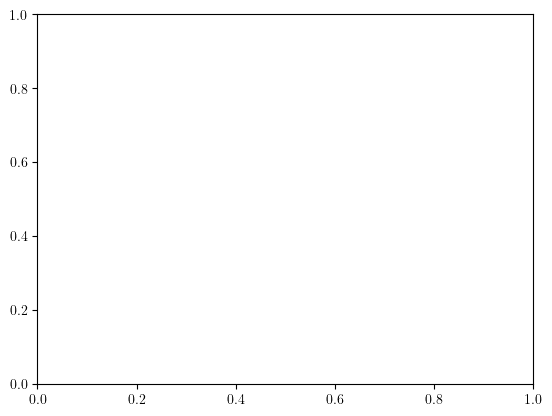

In [14]:
counts = []
for d in datasets_asimov:
    counts.append(d.counts.data.sum())
plt.plot(livetimes, counts)
plt.loglog()
plt.xlabel("Livetime [hr]")
plt.ylabel("Counts")


## Asimov Cases

In [7]:
true_energy = datasets_asimov[0].exposure.geom.axes[0].center.value


shift_neg = -0.1
shift_pos = +0.1
shift_cor = 0.0

tilt_neg = -0.015
tilt_pos = 0.015
tilt_cor = 0


bias, resolution = 0,0
print(tilt_neg)

-0.015


In [8]:
datasets = []
for d in datasets_asimov:
    sys_d_cor = sys_dataset(dataset_asimov= d,
                        shift = shift_cor, 
                        tilt = tilt_cor,
                        bias = bias,
                        resolution = resolution,
                        rnd = False,
                        e_reco_creation=10)
    dataset_cor_N = sys_d_cor.create_dataset()
    datasets.append(dataset_cor_N)

[]

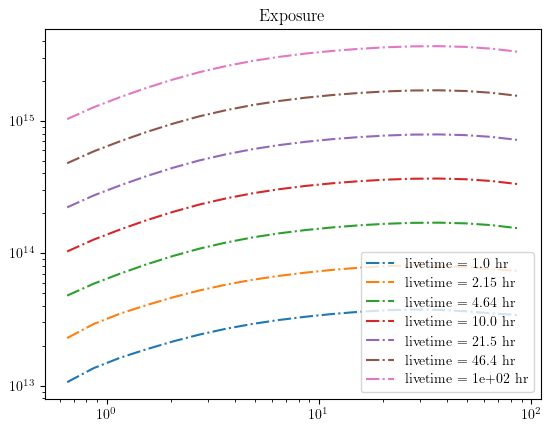

In [9]:
emask = dataset_cor_N.mask.data.sum(axis=2).sum(axis=1) >0 

e_bins = dataset_cor_N.geoms['geom'].axes[0].center.value[emask]

true_energy = dataset_cor_N.exposure.geom.axes[0].center.value[emask]
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)[emask]

for i, d in enumerate(datasets):
    plt.plot(e_bins,sum_e(d.exposure.data ), label = f'livetime = {livetimes[i]:.3} hr', linestyle='-.')

plt.title("Exposure")
plt.legend()
plt.loglog()

[]

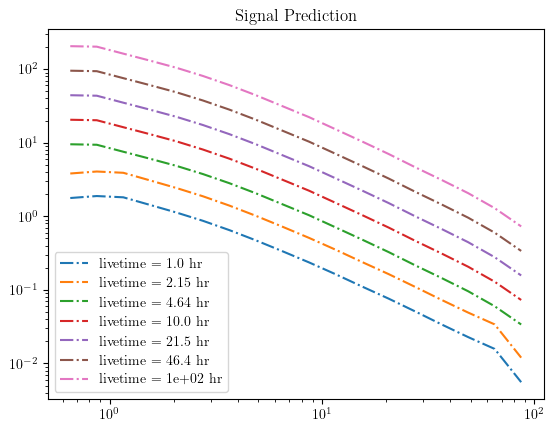

In [10]:

for i, d in enumerate(datasets):
    plt.plot(e_bins,sum_e(d.npred_signal().data ), label = f'livetime = {livetimes[i]:.3} hr', linestyle='-.')

plt.title("Signal Prediction")
plt.legend()
plt.loglog()



[]

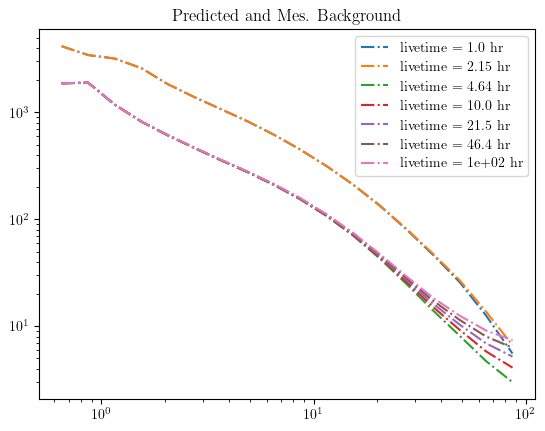

In [12]:
for i, d in enumerate(datasets):
    plt.plot(e_bins,sum_e(d.npred_background().data )+i*1.1, label = f'livetime = {livetimes[i]:.3} hr', linestyle='-.')

plt.title("Predicted and Mes. Background")

plt.legend()
plt.loglog()

In [12]:
%%time
fitting = 1

if fitting:
    for i, d in enumerate(datasets):
        print(i)
        fit_cor = Fit(store_trace=True)
        result_cor = fit_cor.run(d)

    
    
        print("saving")
        path = f'data/8_model_{shift_cor}_tilt_{tilt_cor}_livetime_{livetimes[i]}.yml'
        d.models.write(path,overwrite=True)
    
else:
    print("read")
    for i, d in enumerate(datasets):
        path = f'data/8_model_{shift_cor}_tilt_{tilt_cor}_livetime_{livetimes[i]}.yml'
        datasets[i] = Dataset_load.load_dataset(d, path)        
         
    



0
saving
1
saving
2
saving
3
saving
4
saving
5
saving
6
saving
CPU times: user 1min 21s, sys: 18.5 s, total: 1min 40s
Wall time: 1min 40s


/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


Text(0, 0.5, 'Best Fit Amplitude [1 / (cm2 s TeV)]')

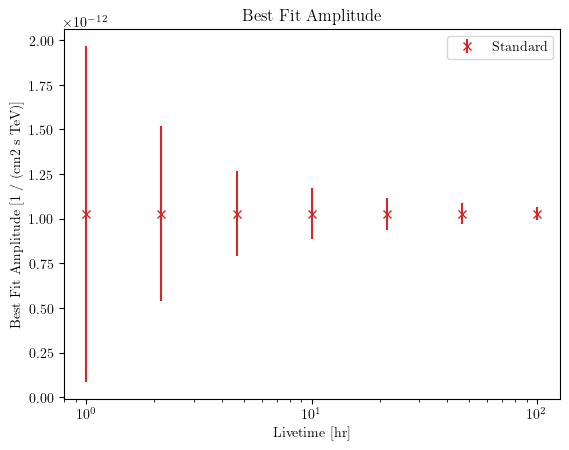

In [13]:
parname = 'amplitude'
for i, d in enumerate(datasets):
    
    par = d.models[0].parameters[parname]
    val, err = par.value, par.error
    plt.errorbar(livetimes[i], val, yerr = err,  fmt='x', color = 'tab:red')

plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:red', label = 'Standard')

    
plt.title("Best Fit Amplitude")
plt.legend()
plt.xscale('log')
plt.xlabel("Livetime [hr]")
plt.ylabel(f"Best Fit Amplitude [{par.unit}]")


Text(0, 0.5, 'Best Fit Index')

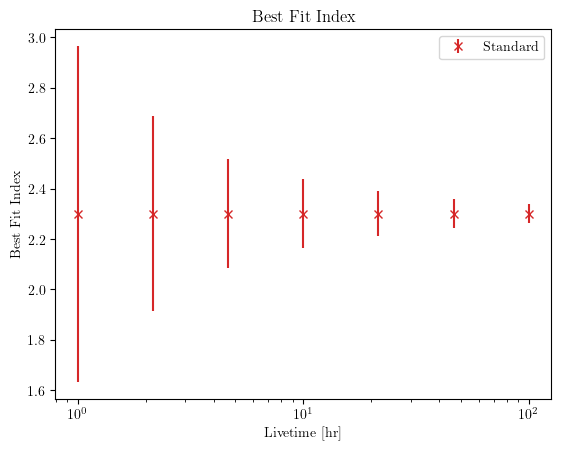

In [14]:
parname = 'index'
for i, d in enumerate(datasets):
    
    par = d.models[0].parameters[parname]
    val, err = par.value, par.error
    plt.errorbar(livetimes[i], val, yerr = err,  fmt='x', color = 'tab:red')
    
plt.errorbar( np.nan, np.nan , yerr = np.nan, fmt='x', color = 'tab:red', label = 'Standard')

plt.title("Best Fit Index")
plt.legend()
plt.xscale('log')
plt.xlabel("Livetime [hr]")
plt.ylabel("Best Fit Index")


## Significancec 

In [15]:
%%time
fitting = 0
datasets_H0 = []
if fitting:
    for i, d in enumerate(datasets):
        print(i)
        with d.models.parameters.restore_status():
            d.models.parameters['amplitude'].value = 0.
            d.models.parameters['amplitude'].frozen = True
            fit_cor = Fit(store_trace=True)
            result_cor = fit_cor.run(d)
            print("saving")
            path = f'data/8_model_H0_{shift_cor}_tilt_{tilt_cor}_livetime_{livetimes[i]}.yml'
            d.models.write(path,overwrite=True)
            datasets_H0.append(d)
else:
    print("read")
    for i, d in enumerate(datasets):
        path = f'data/8_model_H0_{shift_cor}_tilt_{tilt_cor}_livetime_{livetimes[i]}.yml'
        datasets_H0.append(Dataset_load.load_dataset(d, path))
    



read
CPU times: user 587 ms, sys: 213 ms, total: 800 ms
Wall time: 810 ms


Text(0, 0.5, 'Signifiance [$\\sigma$]')

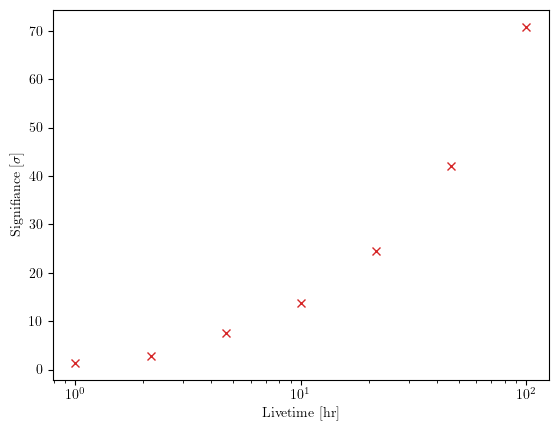

In [16]:
for i, l in enumerate(livetimes):
    H0 = datasets_H0[i].stat_sum()
    H1 = datasets[i].stat_sum()
    plt.plot(l, np.sqrt(np.abs(H0- H1)), marker = 'x', color = 'tab:red')
plt.xscale("log")

plt.xlabel("Livetime [hr]")
plt.ylabel("Signifiance [$\sigma$]")